In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, minmax_scale

from holodecml.data import load_scaled_datasets, load_raw_datasets, calc_z_bins

In [2]:
path_data = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/"
num_particles = "large"
output_cols = ["x", "y", "z", "d", "hid"]
scaler_out = MinMaxScaler()
subset = False
num_z_bins = False
mass = False


In [3]:
train_inputs,\
train_outputs,\
valid_inputs,\
valid_outputs = load_scaled_datasets(path_data,
                                     num_particles,
                                     output_cols,
                                     scaler_out,
                                     subset,
                                     num_z_bins,
                                     mass)


In [4]:
print(train_inputs.shape)
print(train_outputs.shape)
print(valid_inputs.shape)
print(valid_outputs.shape)

(5000, 1200, 800, 1)
(5000, 100, 5)
(1000, 1200, 800, 1)
(1000, 100, 5)


In [5]:
model_path = "/glade/p/cisl/aiml/ggantos/holodec/attention/"
models = [f.path for f in os.scandir(model_path) if f.is_dir()]
models

['/glade/p/cisl/aiml/ggantos/holodec/attention/base',
 '/glade/p/cisl/aiml/ggantos/holodec/attention/base_80',
 '/glade/p/cisl/aiml/ggantos/holodec/attention/base_40']

In [6]:
models.sort()

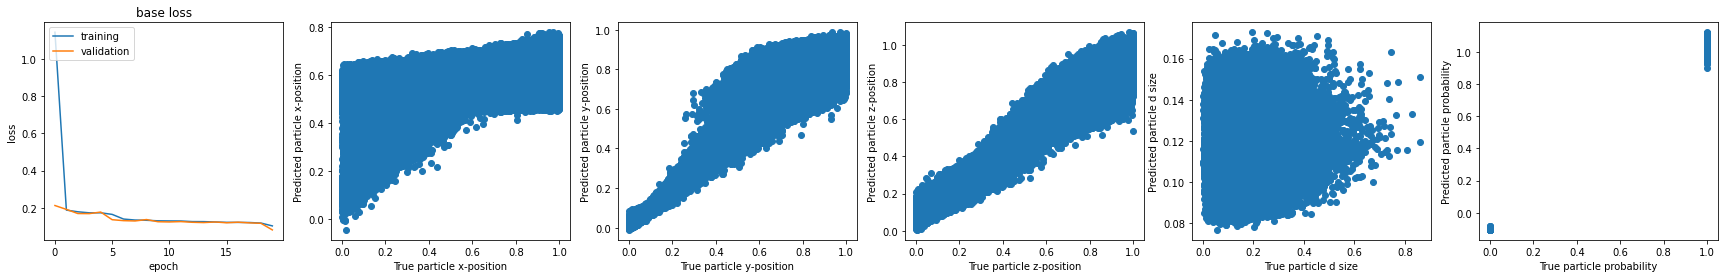

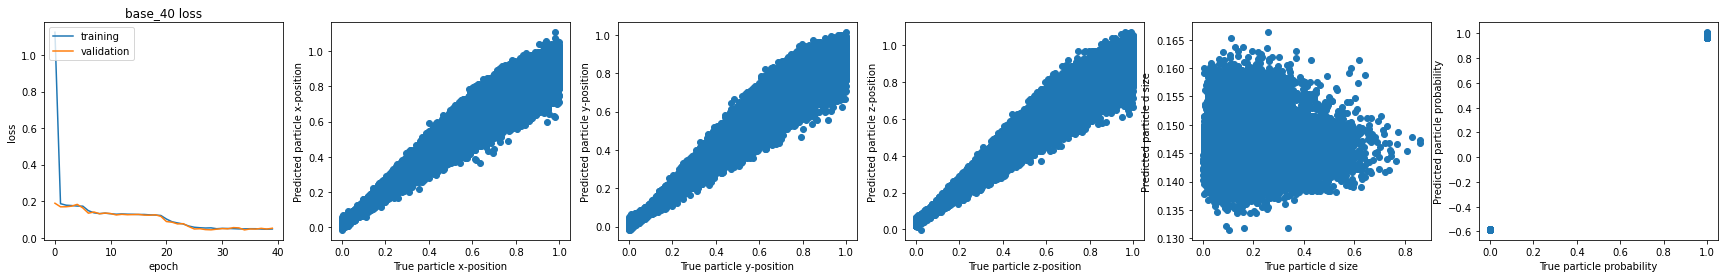

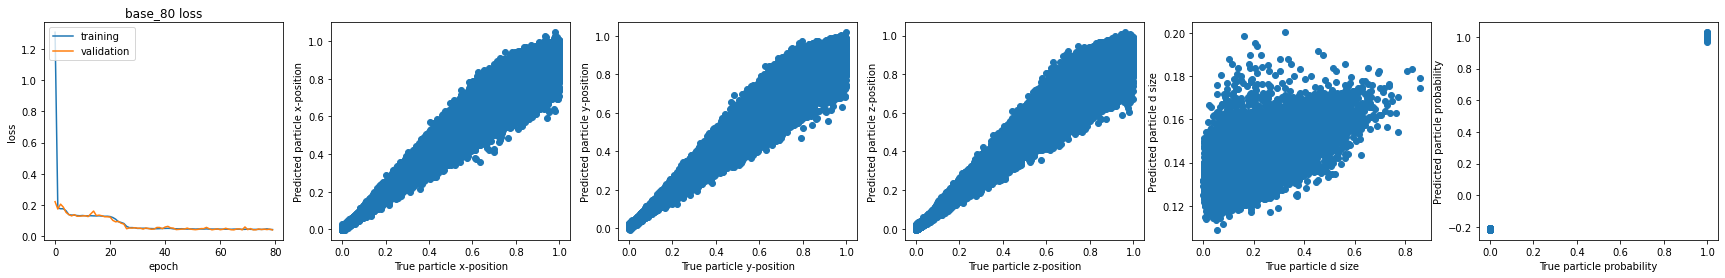

In [8]:
idx_true = valid_outputs[:,:,-1] > 0.5

for m in models:
    model = m[m.rfind('/')+1:]
    valid_outputs_pred = xr.open_dataset(os.path.join(model_path, model, "valid_outputs_pred.nc"))["valid_pred_scaled"].values

    loss = np.genfromtxt(os.path.join(model_path, model, "loss.csv"))
    val_loss = np.genfromtxt(os.path.join(model_path, model, "val_loss.csv"))
    
    fig, axes = plt.subplots(1, 6, figsize=(30, 4))
    axes[0].plot(loss)
    axes[0].plot(val_loss)
    axes[0].set_title(f'{model} loss')
    axes[0].set_ylabel('loss')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['training', 'validation'], loc='upper left')
    
    axes[1].scatter(valid_outputs[idx_true,0], valid_outputs_pred[idx_true,0])
    axes[1].set_xlabel("True particle x-position")
    axes[1].set_ylabel("Predicted particle x-position")
    
    axes[2].scatter(valid_outputs[idx_true,1], valid_outputs_pred[idx_true,1])
    axes[2].set_xlabel("True particle y-position")
    axes[2].set_ylabel("Predicted particle y-position")

    axes[3].scatter(valid_outputs[idx_true,2], valid_outputs_pred[idx_true,2])
    axes[3].set_xlabel("True particle z-position")
    axes[3].set_ylabel("Predicted particle z-position")

    axes[4].scatter(valid_outputs[idx_true,3], valid_outputs_pred[idx_true,3])
    axes[4].set_xlabel("True particle d size")
    axes[4].set_ylabel("Predicted particle d size")

    axes[5].scatter(valid_outputs[:,:,4].flatten(), valid_outputs_pred[:,:,4].flatten())
    axes[5].set_xlabel("True particle probability")
    axes[5].set_ylabel("Predicted particle probability")

    plt.savefig(f"transformer_prelim_results_{model}.png")
    